<a href="https://colab.research.google.com/github/AidanMG/Aero-290-Scripts-Team-8/blob/main/Scripts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aero 290 Project Scripts

**Produced by:** Aidan Mulrooney Gelinas (student no. 40208123)\
**For:** Team 8\
**Semester:** Winter 2023







Note: Please select "runtime -> run all cells" before trying to run any individual cell, since later cells usually depend on earlier cells


In [ ]:
!pip install ambiance shapely==2.0.1
!pip install matplotlib-label-lines
!pip install npconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import pandas as pd
from ambiance import Atmosphere
from shapely.geometry import LineString, MultiPoint

#Common conversion factors
h_to_sec = 3600
km_to_ft = 3280.84
kts_to_fps = 1.68781
kgm3_to_slft3 = 0.00194032 #density conversion factor
pa_to_psf = 0.020885434273039 #pressure conversion factor
deg_to_rad = 0.0174533



#Atmosphere definitions (note that all values are metric, conversion factors are needed)
sealevel = Atmosphere(0)
alt_25k = Atmosphere(25000/km_to_ft)




In [ ]:
#L/D estimate formula from Raymer p.40
def L_D_max_estimate(aspect_ratio, Swet_Sref, ac_type='ret_prop'):
  if ac_type=='ret_prop':
    K_ld = 11
  elif ac_type=='fix_prop':
    K_ld = 9
  elif ac_type=='civ_jet':
    K_ld = 15.5  
  elif ac_type=='mil_jet':
    K_ld = 14
  elif ac_type=='high_ar':
    K_ld = 13
  elif ac_type=='sailplane':
    K_ld = 15

  return K_ld*math.sqrt(aspect_ratio/Swet_Sref)
  

In [ ]:
#Weight calculations

#Final calculation for the MTOW
def mtow(w_crew, w_payload, wf_frac, we_frac):
  #mtow calc
  weight = (w_crew + w_payload) / (1- wf_frac - we_frac)
  return weight

#Using segmented weights definition under https://tc.canada.ca/en/aviation/reference-centre/advisory-circulars/advisory-circular-ac-no-703-004
#as a reference
#Only last row was used, since it represents our design
def pax_weight_est(num, M_to_F_ratio=1, season='winter'):
  if season=='winter': 
    M_weight, F_weight = 229, 193
  elif season=='summer':
    M_weight, F_weight = 223, 187
  avg_weight = F_weight + M_to_F_ratio*(M_weight-F_weight)
  
  return num*avg_weight

def crew_weight_est(num, M_to_F_ratio=1):
  #For now, assume crew weight, is approx. maximum possible passenger weight
  return pax_weight_est(num, M_to_F_ratio)

def we_frac_estimate(w0):
  #empty weight fraction estimated by statistical data, see Raymer. 
  A = 0.96 #constant
  C = -0.05 #constant
  Kvs = 1 #wing sweep constant
  return A*(w0**C)*Kvs

def wf_frac_estimate(R, C_cruise, C_loiter, V, L_D_max, E, ac_type='prop'):
  #R is range (ft)
  #C is specific fuel consumption ()
  #V is velocity (ft/s)
  #L_D_max is maximum lift to drag ratio (x0.866 for descent)
  #E is loiter time (seconds)

  if ac_type=='prop':
    loiter_L_D = 0.866*L_D_max
    cruise_L_D = L_D_max
  elif ac_type=='jet':
    loiter_L_D = L_D_max
    cruise_L_D = 0.866*L_D_max  
  else: 
    raise ValueError("Unrecognized type")

  takeoff_frac = 0.970
  climb_frac = 0.985
  cruise_frac = math.exp((-1*R*C_cruise)/(V*cruise_L_D))
  loiter_frac = math.exp((-1*E*C_loiter)/(loiter_L_D))
  descend_frac = cruise_frac
  landing_frac = 0.995
  reserve = 1.06
  print(cruise_frac)
  # print(takeoff_frac, climb_frac, cruise_frac, loiter_frac, descend_frac, landing_frac)
  return reserve*(1-takeoff_frac*climb_frac*cruise_frac*loiter_frac*descend_frac*landing_frac)

def iterate_weight(w_crew, w_payload, wf_frac, guess, diff):
  w0 = guess
  while True:
    w0_last = w0
    we_frac = we_frac_estimate(w0)
    w0 = mtow(w_crew, w_payload, wf_frac, we_frac)
    if abs(w0-w0_last) < diff:
      break
  return w0

In [ ]:
print('Max Weight Estimates (Max Taxi/Ramp weight, or MTOW if former cannot be found)\n')


#FOR OUR AIRCRAFT
aspect_ratio = 11.08 #aspect ratio estimate
Swet_Sref = 5 #wetted area ratio estimate
L_D_max = L_D_max_estimate(aspect_ratio, Swet_Sref)
R = 500*km_to_ft #Range in ft
C_cruise = 0.5/h_to_sec #
C_loiter = 0.6/h_to_sec #
V = 250*kts_to_fps #speed
w_payload = pax_weight_est(30, 0.5) #30 passengers
w_crew = crew_weight_est(3, 0.5) #3 crew (2 pilot and 1 flight attendant)
E = 1/3*h_to_sec #loiter time estimate



wf_frac = wf_frac_estimate(R, C_cruise, C_loiter, V, L_D_max, E)

w0_guess = 20000
w0 = iterate_weight(w_crew, w_payload, wf_frac, w0_guess, diff=0.005)
 

our_ac_weight = w0
our_ac_we = w0*we_frac_estimate(w0)

print(f"OUR AIRCRAFT:           {w0:.2f} lbs")
print('---------------------------------------------------------')


#-----------------------------------------------------------------------------
#BENCHMARK FOR ATR42-300 model
#Actual max weight ): 17070kg = 37257lbs

#SOURCES:
# [1] Main stat sheet: http://www.atr-aircraft.com/wp-content/uploads/2020/07/42-300.pdf
# [2] Research paper on modelling the PW120: http://www.srs.aero/wordpress/wp-content/uploads/2009/03/srs-tsd-002-rev-1-pw120a-sfc-analysis.pdf 

#Data for PW120A (power plant used by ATR-42-300)
aspect_ratio = 11.08 #actual, from [1] (span^2/area)
Swet_Sref =  5 #estimate
L_D_max = L_D_max_estimate(aspect_ratio, Swet_Sref)
R = 831.548*km_to_ft #Range in ft [1], converted from nm to km then to feet
C_cruise = 0.498/h_to_sec #from [2], converted, table 4.2 @ 25000ft
C_loiter = C_cruise*(0.6/0.5) #Assuming same C_cruise/C_loiter fraction as historical
V = 266*kts_to_fps #typical max pax. cruise speed, [1]
w_payload = pax_weight_est(48, 0.5) #48 passengers [1]
w_crew = crew_weight_est(3) #3 crew (2 pilot and 1 flight attendant) assumed
E = 1/3*h_to_sec #loiter time (same as ours, no real reference for this other than Raymer I think?)

wf_frac = wf_frac_estimate(R, C_cruise, C_loiter, V, L_D_max, E)
w0_guess = 40000
w0 = iterate_weight(w_crew, w_payload, wf_frac, w0_guess, diff=0.005)

atr_weight = 37257
print(f"ATR-42-300 ESTIMATE:    {w0:.2f} lbs")
print("ATR-42-300 ACTUAL:      37257.00 lbs")
print('---------------------------------------------------------')
#-----------------------------------------------------------------------------
#BENCHMARK FOR DORNIER 328
#[1] Stats sheet: https://www.globalair.com/aircraft-for-sale/specifications?specid=716 
#[2] secondary stats sheet: https://jetav.com/fairchild-dornier-do-328-120-performance-specs/ 

aspect_ratio = (68+10/12)**2/431 #from [1]
Swet_Sref =  5 #estimate
L_D_max = L_D_max_estimate(aspect_ratio, Swet_Sref)
R = 2222*km_to_ft #Range in ft, from, assuming normal range [1]
C_cruise = 0.5/h_to_sec #estimate (Raymer)
C_loiter = 0.6/h_to_sec #estimate (Raymer)
V = 400*kts_to_fps #Cruise speed, from [1]
w_payload = pax_weight_est(33, 0.5) #33 passengers [1]
w_crew = crew_weight_est(3) #3 crew
E = 1/3*h_to_sec #loiter time

wf_frac = wf_frac_estimate(R, C_cruise, C_loiter, V, L_D_max, E)
w0_guess = 20000
w0 = iterate_weight(w_crew, w_payload, wf_frac, w0_guess, diff=0.005)

do328_weight = w0

print(f"DO-328 ESTIMATE:        {w0:.2f} lbs")
print("DO-328 ACTUAL:          34525.00 lbs")
print('---------------------------------------------------------')
#-----------------------------------------------------------------------------
#BENCHMARK FOR DHC-8-100
#DO NOT USE -- NO GOOD RESOURCE FOR DHC-8-100
print('***DO NOT USE DHC-8-100, UNRELIABLE/CONFLICTING SOURCES***')
aspect_ratio = 12.32 #Based on Dash 8-200, might be close?
Swet_Sref = 5 #THIS IS PROBABLY WRONG
L_D_max = L_D_max_estimate(aspect_ratio, Swet_Sref)
R = 1448*km_to_ft #Range in ft [2]
C_cruise = 0.5/h_to_sec
C_loiter = 0.6/h_to_sec
V = 250*kts_to_fps #speed [2]
w_payload = pax_weight_est(37, 0.5) #37 passengers
w_crew = crew_weight_est(3) #3 crew (2 pilot and 1 flight attendant)
E = 1/3*h_to_sec #loiter time estimate

wf_frac = wf_frac_estimate(R, C_cruise, C_loiter, V, L_D_max, E)
w0_guess = 30000
w0 = iterate_weight(w_crew, w_payload, wf_frac, w0_guess, diff=0.005)

dhc100_weight = w0

print(f"DHC-8-100 ESTIMATE:     {w0:.2f} lbs")
print("DHC-8-100 ACTUAL:       34700.00 lbs") #https://dehavillandportal.com/assets/public-documents/D8100-APM.pdf Max Taxi Weight [1]
#https://perimeter.ca/planes/dash-8-100s/#:~:text=The%20Dash%208%2D100%20commuter,the%20larger%20Dash%208%2D300. [2]



Max Weight Estimates (Max Taxi/Ramp weight, or MTOW if former cannot be found)

0.9675629961237099
OUR AIRCRAFT:           23978.56 lbs
---------------------------------------------------------
0.949960055450495
ATR-42-300 ESTIMATE:    39844.05 lbs
ATR-42-300 ACTUAL:      37257.00 lbs
---------------------------------------------------------
0.9121520151661232
DO-328 ESTIMATE:        38211.63 lbs
DO-328 ACTUAL:          34525.00 lbs
---------------------------------------------------------
***DO NOT USE DHC-8-100, UNRELIABLE/CONFLICTING SOURCES***
0.9134179839831077
DHC-8-100 ESTIMATE:     41356.84 lbs
DHC-8-100 ACTUAL:       34700.00 lbs


In [ ]:
#CONSTRAINT 1 - Takeoff Length

def takeoff_len_raymer(TOP, sigma, CL_to, hp_W):
  """
  Raymer's equation: 
  W_S = TOP*sigma*CL_to*(hp/W)
  W_S : wing loading
  TOP: Takeoff parameter, graphically
  sigma: Air density ratio
  CL_to = Coefficient of lift at takeoff
  """
  return TOP*sigma*CL_to*hp_W

def takeoff_len_gud(CL_to, CD_to, CL_max, Sg, mu, rho, V_LOF, W_S):
  """
  Gudmundsson's equation (ground run distance):
  T/W = 1.21/(g*rho*CL_max*Sg)*W_S + (0.605/CL_max)*(CD_to-mu*CL_to) + mu
  
  CL_to: takeoff CL
  CD_to: takeoff CD
  CL_max: Max CL in TO config
  Sg: Ground run (ft)
  mu: Ground friction constant (typ. 0.04)
  g: Acceleration due to gravition (ft/s^2)
  rho: Air density (slug/ft^3)

  Convert to P_W:
  P_W=T_W*V/(p_eff*550)
  for takeoff, Vavg = V_LOF/sqrt(2)
  V_LOF: liftoff velocity
  """
  g = 32.185
  p_eff = 0.5 #for consant speed prop for full takeoff
  T_W = 1.21/(g*rho*CL_max*Sg)*W_S + (0.605/CL_max)*(CD_to-mu*CL_to) + mu
  P_W = T_W*(V_LOF/math.sqrt(2))/(p_eff*550)
  sigma = rho/(Atmosphere(0).density*kgm3_to_slft3)

  P_W_sl = P_W/(1.132*sigma - 0.132)

  return P_W_sl

In [ ]:
#CONSTRAINT 2 - Rate of Climb

#Raymer
def climb_rate_raymer(L_D_climb, V_y, V_vert, w_frac):
  """
  """
  V_y*=kts_to_fps

  T_W = 1/L_D_climb + V_vert/V_y
  p_eff = 0.75 #typical cruise prop efficiency, constant speed propeller
  eshp = 1 #equivalent shaft horse power at cruise, divide by this to normailze to takeoff power

  P_W = ((T_W/w_frac)*eshp)*(V_y)/(p_eff*550)
  return P_W

def climb_rate_gud(V_vert, alt, AR, e, CD_min, w_frac, W_S):
  """
  Gudmundsonn's equation:
  T_W = V_vert/V_y + q/(W_S)*CD_min+k/q*(W_S)
  V_y = 69.952+1.3402*(W_S)

  k=1/(math.pi*AR*e)
  q=rho*(V_y**2)/2


  P_W conversion to sea-level thrust:
  P_W_sl = P_W/(1.132*sigma-0.132)
  """
  p_eff = 0.8
  rho = Atmosphere(alt/km_to_ft*1000).density*kgm3_to_slft3
  sigma = rho/(Atmosphere(0/km_to_ft*1000).density*kgm3_to_slft3)
  V_y = 69.952+1.3402*(W_S) #from Gudmundsson

  q=rho*(V_y**2)/2

  k=1/(math.pi*AR*e)


  T_W = V_vert/V_y + q/(W_S)*CD_min+k/q*(W_S)


  P_W = ((T_W/w_frac))*(V_y)/(p_eff*550)

  P_W_sl=P_W/(1.132*sigma - 0.132)

  return P_W_sl

In [ ]:
#CONSTRAINT 4 - Level turn

def level_turn(CD_min, V_turn, AR, e, bank_angle, alt, w_frac, W_S):
  """
  T_W = q*(CD_min/W_S + k*(n**2/q)*W_S)
  """
  p_eff = 0.8
  eshp = 0.8
  n = 1/(math.cos(bank_angle*deg_to_rad))

  rho = Atmosphere(alt/km_to_ft*1000).density*kgm3_to_slft3
  sigma = rho/(Atmosphere(0).density*kgm3_to_slft3)

  q=rho*(V_turn**2)/2
  k=1/(AR*e*math.pi)

  T_W = q*(CD_min/W_S + k*((n/q)**2)*W_S)

  P_W = ((T_W/w_frac)*eshp)*(V_turn)/(p_eff*550)

  P_W_sl=P_W/(1.132*sigma - 0.132)


  return P_W_sl


In [ ]:
#CONSTRAINT 5 - Climbing turn

def climb_turn(CD_min, V_turn, V_vert, AR, e, bank_angle, alt, w_frac, W_S):
  """
  T_W = q*(CD_min/W_S + k*(n**2/q)*W_S) + V_vert/V_turn
  """
  p_eff = 0.8
  eshp = 0.8
  n = 1/(math.cos(bank_angle*deg_to_rad))

  rho = Atmosphere(alt/km_to_ft*1000).density*kgm3_to_slft3
  sigma = rho/(Atmosphere(0).density*kgm3_to_slft3)

  q=rho*(V_turn**2)/2
  k=1/(AR*e*math.pi)

  T_W = q*(CD_min/W_S + k*((n/q)**2)*W_S) + V_vert/V_turn

  P_W = ((T_W/w_frac)*eshp)*(V_turn)/(p_eff*550)

  P_W_sl=P_W/(1.132*sigma - 0.132)


  return P_W_sl

In [ ]:
#CONSTRAINT 6 - Cruise Speed

#Raymer
def cruise_speed_raymer(L_D_max, V_max, w_frac):
  """
  Raymer's equation for Cruise Speed

  Greater of: 1/(L_D_max) OR aV_max^C (a, C from a table)
  IMPORTANT: V_max in Kts for this equation

  Note: 
  1-This is at cruise, so the weight fraction between initial and cruise must be applied
  2-Conversion is necessary from T_W to P_W is also necessary, and 
  3-The statistical value is WAY too high, at least when compared to real-world examples
  """
  V_kts = V_max
  V_max*=kts_to_fps

  a = 0.013
  c = 0.50
  T_W = 1/L_D_max
  
  p_eff = 0.75 #typical cruise prop efficiency, constant speed propeller
  eshp = 0.7 #equivalent shaft horse power at cruise, divide by this to normailze to takeoff power

  P_W = ((T_W/w_frac)*eshp)*(V_max)/(p_eff*550)
  P_W = max(P_W, a*(V_kts**c)*eshp)
  return P_W

#Gudmundsson
def cruise_speed_gud(alt, V_cruise, w_frac, AR, e, CD_min, W_S):
  """
  Gudmundsson's equation for cruise speed

  T_W = q*CD_min*(1/W_S) + k*(1/q)*W_S
  q: dynamic pressure at altitude and speed
    q=rho*(V_cruise**2)/2
  k: lift-induced drag constant from drag polar (https://agodemar.github.io/FlightMechanics4Pilots/mypages/drag-polar/#:~:text=K%3D1%CF%80AR,includes%20all%20effects%20from%20airplane.)
    k=1/(AR*e*math.pi())

  P_W conversion to sea-level thrust:
  P_W_sl = P_W/(1.132*sigma-0.132)
  """
  p_eff = 0.8
  eshp=0.8

  rho = Atmosphere(alt/km_to_ft*1000).density*kgm3_to_slft3
  sigma = rho/(Atmosphere(0).density*kgm3_to_slft3)

  q=rho*(V_cruise**2)/2
  k=1/(AR*e*math.pi)

  T_W = q*CD_min*(1/W_S) + k*(1/q)*W_S

  P_W = ((T_W/w_frac)*eshp)*(V_cruise)/(p_eff*550)

  P_W_sl=P_W/(1.132*sigma - 0.132)


  return P_W_sl




In [ ]:
#CONSTRAINT 9 - Landing Distance

def landing_distance_raymer(dens_ratio, S_a, S_landing, CL_max):
    W_S = (S_landing-S_a)*dens_ratio*CL_max/80
    return W_S

def landing_distance_gud(h_obst, t_roll, alt, CLmax_ldg, g, CL_ldg, mu_ldg, CD_ldg, T_gr_W, S_ldg, W_S, w_frac):
  """
  Gudmundsonn's equation:
  S_ldg = 19.08*h_obst + \
        (0.007923+1.556*t_roll*math.sqrt(rho*CLmax_ldg/W_S) + \
          1.21/(g*(0.605/CLmax_ldg*(CD_ldg-mu_ldg*CL_ldg) + mu_ldg - T_gr_W) \
          ) *W_S/(rho*CL_max_l)
  therefore 

  W_S = (S_ldg-19.08*h_obst) * (rho*CL_max_l) / \
          (0.007923+1.556*t_roll*math.sqrt(rho*CLmax_ldg/W_S) + \
          1.21/(g*(0.605/CLmax_ldg*(CD_ldg-mu_ldg*CL_ldg) + mu_ldg - T_gr_W)

  """
  rho = Atmosphere(alt/km_to_ft*1000).density*kgm3_to_slft3


  W_S = (S_ldg-19.08*h_obst) * (rho*CLmax_ldg) / \
          (0.007923+1.556*t_roll*math.sqrt(rho*CLmax_ldg/W_S) + \
          1.21/(g*(0.605/CLmax_ldg*(CD_ldg-mu_ldg*CL_ldg) + mu_ldg - T_gr_W)))
  W_S = W_S/w_frac_climb


  

  return W_S[0]

def iterate_ldg(h_obst, t_roll, alt, CLmax_ldg, g, CL_ldg, mu_ldg, CD_ldg, T_gr_W, S_ldg, W_S_guess, w_frac, diff=0.1):
  W_S_new = landing_distance_gud(h_obst, t_roll, alt, CLmax_ldg, g, CL_ldg, mu_ldg, CD_ldg, T_gr_W, S_ldg, W_S_guess, w_frac)
  if abs(W_S_new-W_S_guess)<=diff:
    return W_S_new
  else:
    return iterate_ldg(h_obst, t_roll, alt, CLmax_ldg, g, CL_ldg, mu_ldg, CD_ldg, T_gr_W, S_ldg, W_S_new, w_frac, diff=0.1)




In [ ]:
#CONSTRAINT 10 - Stall Speed / Landing Speed

#Using data from https://www.theairlinepilots.com/forumarchive/atr/fctm-norm-proc.pdf p.196/211,
#ATR 42 is in class B, Vat (velocity at threshold, minimum approach vel. = 1.3xVstall) is between 89 and 120kts inclusive.
#Assume our plane will also be class B, assume 120kts Vat. until we find stall speed
#This is the minimum speed, altitude should be selected as LANDING altitude

def stall_speed(v_stall, alt, CL_max):
  rho = Atmosphere(alt/km_to_ft*1000).density*kgm3_to_slft3
  W_S = 1/2*rho*((v_stall*kts_to_fps)**2)*CL_max

  return W_S

In [ ]:
#finds the intercept of two arrays
def intersect(x1,f1,x2,f2, shape='o', *args, **kwargs):
  first_line = LineString(np.column_stack((x1, f1)))
  second_line = LineString(np.column_stack((x2, f2)))
  inter = first_line.intersection(second_line)


  if inter.geom_type == 'MultiPoint':
    pt_list = list(inter.geoms)
    x, y = [], []
    for pt in pt_list:
      x.append(pt.xy[0])
      y.append(pt.xy[1])
    plt.plot(x,y, shape, **kwargs)
  elif inter.geom_type == 'Point':
    plt.plot(*inter.xy, shape, **kwargs)



<ipython-input-9-279aa1c6f84d>:39: RuntimeWarning: divide by zero encountered in true_divide
  T_W = V_vert/V_y + q/(W_S)*CD_min+k/q*(W_S)
<ipython-input-10-b2c03bb909c4>:17: RuntimeWarning: divide by zero encountered in true_divide
  T_W = q*(CD_min/W_S + k*((n/q)**2)*W_S)
<ipython-input-12-7488a404f0c3>:53: RuntimeWarning: divide by zero encountered in true_divide
  T_W = q*CD_min*(1/W_S) + k*(1/q)*W_S


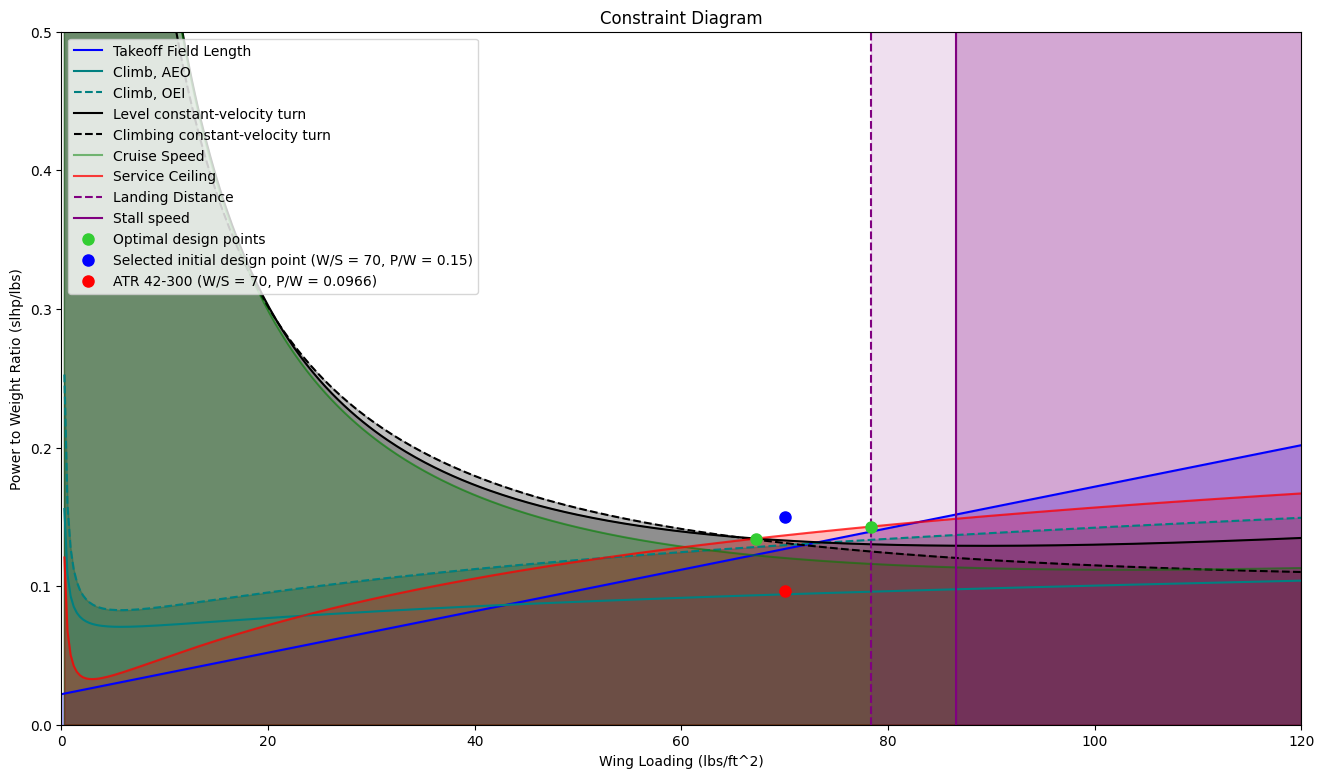

In [ ]:




#constraint diagram -- wing loading and power loading, how to connect 
#constraint diagram plotting

RES = 400 #default number of points per curve

W_S_ref = np.linspace(0,120,RES) #reference, default W_S values to use for a plot
P_W_ref = np.linspace(0,0.5,RES) #reference, default P_W values to use for a plot

fig, ax = plt.subplots()

#VARIABLES:
cruise_alt = 20000                            #Cruise altitude (ft)

CL_to = 0.8                                   #Coefficient of Lift in Takeoff Config.
CD_to = 0.04                                  #Coefficient of Drag in Takeoff Config.
CL_max_to = 2.1                               #Max CL in Takeoff Config. 
Sg = 0.8*km_to_ft                             #Ground run distance (800m, in ft)
mu_takeoff = 0.04                             #Takeoff param. 'mu'
rho_sl = Atmosphere(0).density*kgm3_to_slft3  #Air density at sea level, in sl/ft^3
V_lof = 100*kts_to_fps                        #liftoff speed in fps

L_D_climb = 17                                #Climb L/D estimate
V_vert = 1500/60                              #Vertical speed of climb, fps, AEO
climb_alt = 0
w_frac_climb = 0.97                           #Total accumulated weight fraction during climb

w_frac_cruise = 0.97*0.985                    

AR = 11.08
e = 0.8
CD_min=0.03

V_cruise = 250*kts_to_fps

h_obst = 35                                   #Obstacle height (ft)
t_roll = 1                                    #Roll time before brakes applied (seconds)
alt_ldg = 0                                   #Landing altitude
CL_max_ldg = 2.25                             #CLmax in landing config 
g = Atmosphere(alt_ldg/km_to_ft*1000).grav_accel*(km_to_ft/1000) #g
CL_ldg = 0.5                                  #CL_ldg (assumed)
CD_ldg = 0.07                                 #CD_ldg (assumed)
mu_ldg = 0.35                                 #ground friction (assumed)
T_gr_W = 0                                    #idle T_W (assume 0 for now)
S_ldg = 800*km_to_ft/1000                     #Total landing distance, ft


bank_angle = 30
w_frac_turn = 0.97*0.985
V_turn = 250*kts_to_fps
alt_turn = cruise_alt


V_turn_vert = 1500/60
turn_climb_alt = 0            

w_frac_landing = 0.97                         #WORST CASE SCENARIO: landing immediately after takeoff

#CONSTRAINT 1 - TAKEOFF FIELD LENGTH
#Raymer
#
# cstr_1a = takeoff_len_raymer(TOP=265,sigma=1,CL_to=2.1,hp_W=P_W_ref)
# ax.plot(cstr_1a, P_W_ref, color='blue', ls='--', alpha=0.5)
# ax.fill_between(cstr_1a, P_W_ref, color='blue', alpha=0.25)

#Gudmundsson
cstr_1b = takeoff_len_gud(CL_to, CD_to, CL_max_to, Sg=2620, mu=0.04, rho=0.0023769, V_LOF=120*kts_to_fps, W_S=W_S_ref)
ax.plot(W_S_ref, cstr_1b, color='blue', label='Takeoff Field Length')
ax.fill_between(W_S_ref, cstr_1b, color='blue', alpha=0.25)

#CONSTRAINT 2 - CLIMB RATE
cstr_2a = climb_rate_gud(V_vert, climb_alt, AR, e, CD_min, w_frac_climb, W_S_ref)
ax.plot(W_S_ref, cstr_2a, color='teal', label='Climb, AEO')

V_vert = 750/60
cstr_2b = climb_rate_gud(V_vert, climb_alt, AR, e, CD_min, w_frac_climb, W_S_ref)*2
ax.plot(W_S_ref, cstr_2b, color='teal', ls='--', label='Climb, OEI')
ax.fill_between(W_S_ref, cstr_2b, color='teal', alpha=0.25)


#CONSTRAINT 4 - Level Constant Velocity Turn
cstr_4 = level_turn(CD_min, V_turn, AR, e, bank_angle, alt_turn, w_frac_turn, W_S_ref)
ax.plot(W_S_ref, cstr_4, color='black', label='Level constant-velocity turn')
ax.fill_between(W_S_ref, cstr_4, color='black', alpha=0.25)

#CONSTRAINT 5 - Climbing Constant Velocity Turn
cstr_5 = climb_turn(CD_min, V_turn, V_turn_vert, AR, e, bank_angle, turn_climb_alt, w_frac_climb, W_S_ref)
ax.plot(W_S_ref, cstr_5, color='black', ls='--', label='Climbing constant-velocity turn')
ax.fill_between(W_S_ref, cstr_5, color='black', alpha=0.25)

#CONSTRAINT 6 - Cruise Speed

cstr_6b = cruise_speed_gud(cruise_alt, V_cruise, w_frac_cruise, AR, e, CD_min, W_S_ref)
ax.plot(W_S_ref, cstr_6b, color='green', alpha=0.5, label='Cruise Speed')
ax.fill_between(W_S_ref, cstr_6b, color='green', alpha=0.25)

#CONSTRAINT 7 - Service Ceiling

cstr_7 = climb_rate_gud(V_vert=100/60, alt=cruise_alt, AR=AR, e=e, CD_min=CD_min, w_frac=w_frac_cruise, W_S=W_S_ref)
ax.plot(W_S_ref, cstr_7, color='red', alpha=0.75, label='Service Ceiling')
ax.fill_between(W_S_ref, cstr_7, color='red', alpha=0.25)


#CONSTRAINT 9 - Landing Distance

W_S_ldg_gud = iterate_ldg(h_obst, t_roll, alt_ldg, CL_max_ldg, g, CL_ldg, mu_ldg, CD_ldg, T_gr_W, S_ldg, 50, w_frac_landing)

cstr_9b = np.full(RES, W_S_ldg_gud)
ax.plot(cstr_9b, P_W_ref, color='purple', ls='--', label='Landing Distance')
ax.axvspan(cstr_9b[0], 200, color='purple', alpha=0.125)

#CONSTRAINT 10 - Stall Speed
cstr_10 = np.full(RES, stall_speed(120/1.3, 0, 3))
ax.plot(cstr_10, P_W_ref, color='purple', label='Stall speed')
ax.axvspan(cstr_10[0], 200, color='purple', alpha=0.25)


#DESIGN POINTS
plt.xlim(0,120)
plt.ylim(0,0.5)

fig.set_size_inches(16, 9)

plt.ylabel('Power to Weight Ratio (slhp/lbs)')
plt.xlabel('Wing Loading (lbs/ft^2)')
plt.title('Constraint Diagram')
intersect(W_S_ref, cstr_7, cstr_9b, P_W_ref, color='limegreen', label='Optimal design points', markersize=8)
intersect(W_S_ref[1:], cstr_7[1:], W_S_ref[1:], cstr_4[1:], color='limegreen', markersize=8)

plt.plot(70, 0.15, 'ob', label='Selected initial design point (W/S = 70, P/W = 0.15)', markersize=8)



#[https://www.atr-aircraft.com/wp-content/uploads/2020/07/42-300.pdf]
#ATR 42-300 has P/W of 3600/37257=0.0966
plt.plot(70, 0.0966, 'or', label='ATR 42-300 (W/S = 70, P/W = 0.0966)', markersize=8)

ax.legend()
fig.savefig('constraint_diagram.pdf')
plt.show()

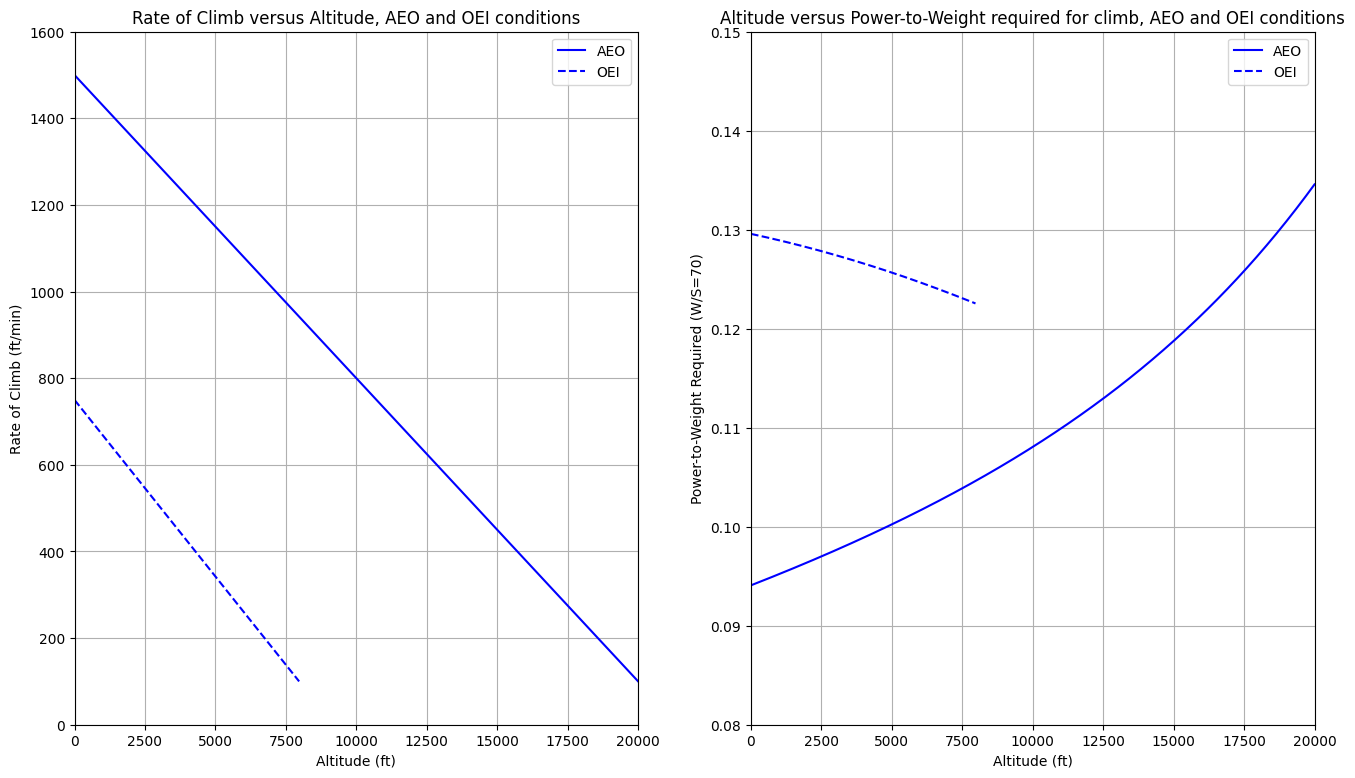

In [ ]:
#rate of climb graph vs altitude

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.set_xlim(0, cruise_alt)
ax1.set_ylim(0, 1600)
ax1.grid()
ax1.set_title('Rate of Climb versus Altitude, AEO and OEI conditions')
ax1.set_ylabel('Rate of Climb (ft/min)')
ax1.set_xlabel('Altitude (ft)')

W_S = 70

alt_array = np.linspace(0, cruise_alt, RES)
aeo_roc_alt = np.linspace(1500, 100, RES)
oei_roc_alt = np.linspace(750 , 100, round(RES/2.5))
ax1.plot(alt_array, aeo_roc_alt, color='blue', label='AEO')
ax1.plot(alt_array[0:round(RES/2.5)], oei_roc_alt, ls='--', color='blue', label='OEI')
fig.set_size_inches(16,9)
ax1.legend()


pw_required = climb_rate_gud(aeo_roc_alt/60, alt_array, AR, e, CD_min, w_frac_climb, W_S)
pw_oei = climb_rate_gud(oei_roc_alt/60, alt_array[0:round(RES/2.5)], AR, e, CD_min, w_frac_climb, W_S)*2

ax2.set_xlim(0, cruise_alt)
ax2.set_ylim(0.08, 0.15)
ax2.grid()
ax2.set_title('Altitude versus Power-to-Weight required for climb, AEO and OEI conditions')
ax2.set_ylabel('Power-to-Weight Required (W/S=70)')
ax2.set_xlabel('Altitude (ft)')

ax2.plot(alt_array, pw_required, color='blue', label='AEO')
ax2.plot(alt_array[0:round(RES/2.5)], pw_oei, color='blue', ls='--', label='OEI')
ax2.legend()



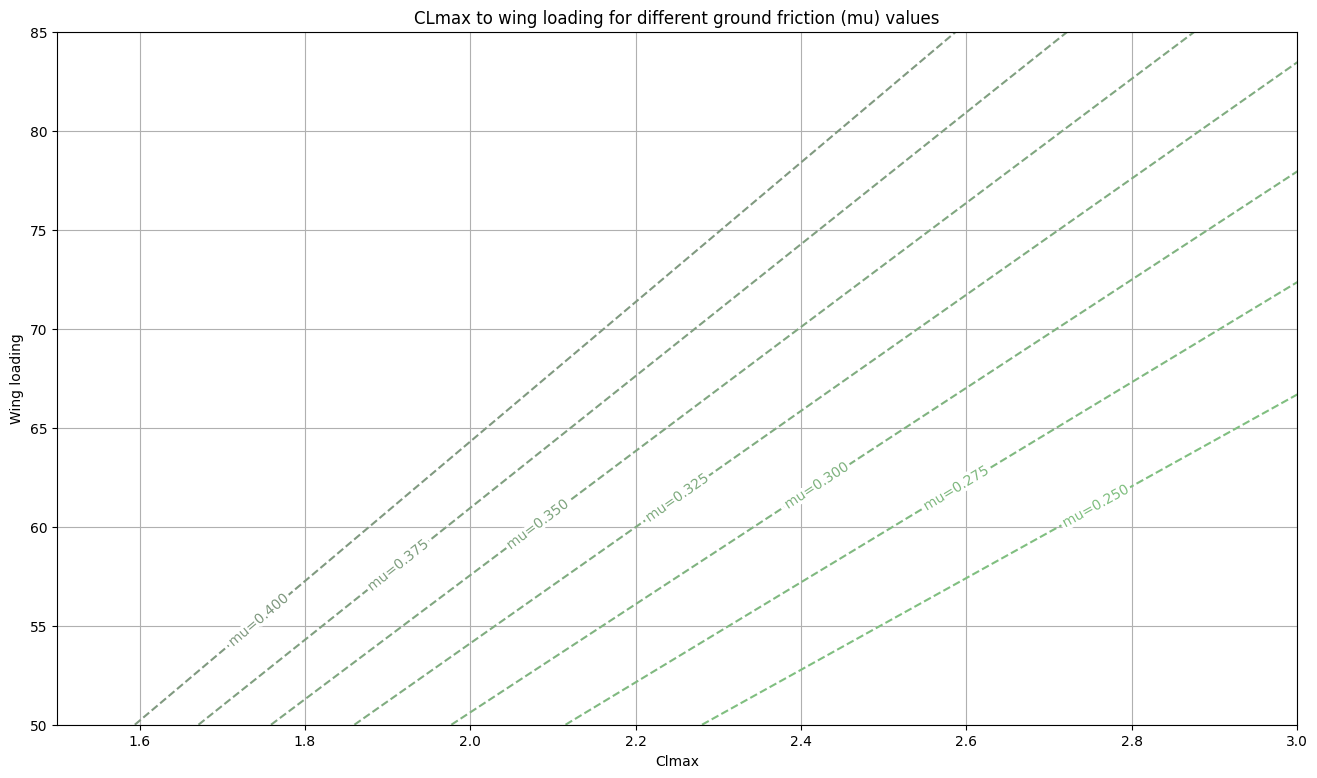

In [ ]:
#CLMAX INVESTIGATION
from scipy.optimize import fsolve
from labellines import labelLine, labelLines


  # W_S = (S_ldg-19.08*h_obst) * (rho*CLmax_ldg) / \
  #         (0.007923+1.556*t_roll*math.sqrt(rho*CLmax_ldg/W_S) + \
  #         1.21/(g*(0.605/CLmax_ldg*(CD_ldg-mu_ldg*CL_ldg) + mu_ldg - T_gr_W)))
  # W_S = W_S/w_frac_climb


#Using http://www.atr-aircraft.com/wp-content/uploads/2020/07/42-300.pdf

#Good resource for ATR42-300 braking:
#https://www.theairlinepilots.com/forumarchive/atr/atr-cold-weather-operations.pdf
#W_S at MLW
W_S_landing_arr = np.linspace(50, 85, 15)

fig, ax = plt.subplots()

rho = sealevel.density*kgm3_to_slft3
h_obst = 35                                   #Obstacle height (ft)
t_roll = 1                                    #Roll time before brakes applied (seconds)
alt_ldg = 5000                                   #Landing altitude                           
g = Atmosphere(alt_ldg/km_to_ft*1000).grav_accel*(km_to_ft/1000) #g
rho = Atmosphere(alt_ldg/km_to_ft*1000).density*kgm3_to_slft3
CL_ldg = 0.5                                  #CL_ldg (assumed)
CD_ldg = 0.07                                 #CD_ldg (assumed)
mu_ldg = 0.3                                  #ground friction (assumed)
T_gr_W = 0                                    #idle T_W (assume 0 for now)
S_ldg = 0.8*km_to_ft                          #Total landing distance, ft

val = lambda CLmax_ldg, W_S:  W_S - (S_ldg-19.08*h_obst) * (rho*CLmax_ldg) / \
        (0.007923+1.556*t_roll*math.sqrt(rho*CLmax_ldg/W_S) + \
        1.21/(g*(0.605/CLmax_ldg*(CD_ldg-mu_ldg*CL_ldg) + mu_ldg - T_gr_W)))

mu = np.arange(0.25, 0.4, 0.025)

for mu_ldg in mu:
  CL = (fsolve(val, x0=1, args=W_S)[0] for W_S in W_S_landing_arr)
  CL = list(CL)
  ax.plot(CL, W_S_landing_arr, color=( 0.5, (1-mu_ldg), 0.5, 1), ls='--', label=f'mu={mu_ldg:.3f}')

plt.ylabel('Wing loading')
plt.xlabel('Clmax')
plt.title('CLmax to wing loading for different ground friction (mu) values')
plt.grid()
plt.xlim(1.5, 3), plt.ylim(50,85)
labelLines(ax.lines, zorder=2.5)
fig.set_size_inches(16, 9)

plt.show()



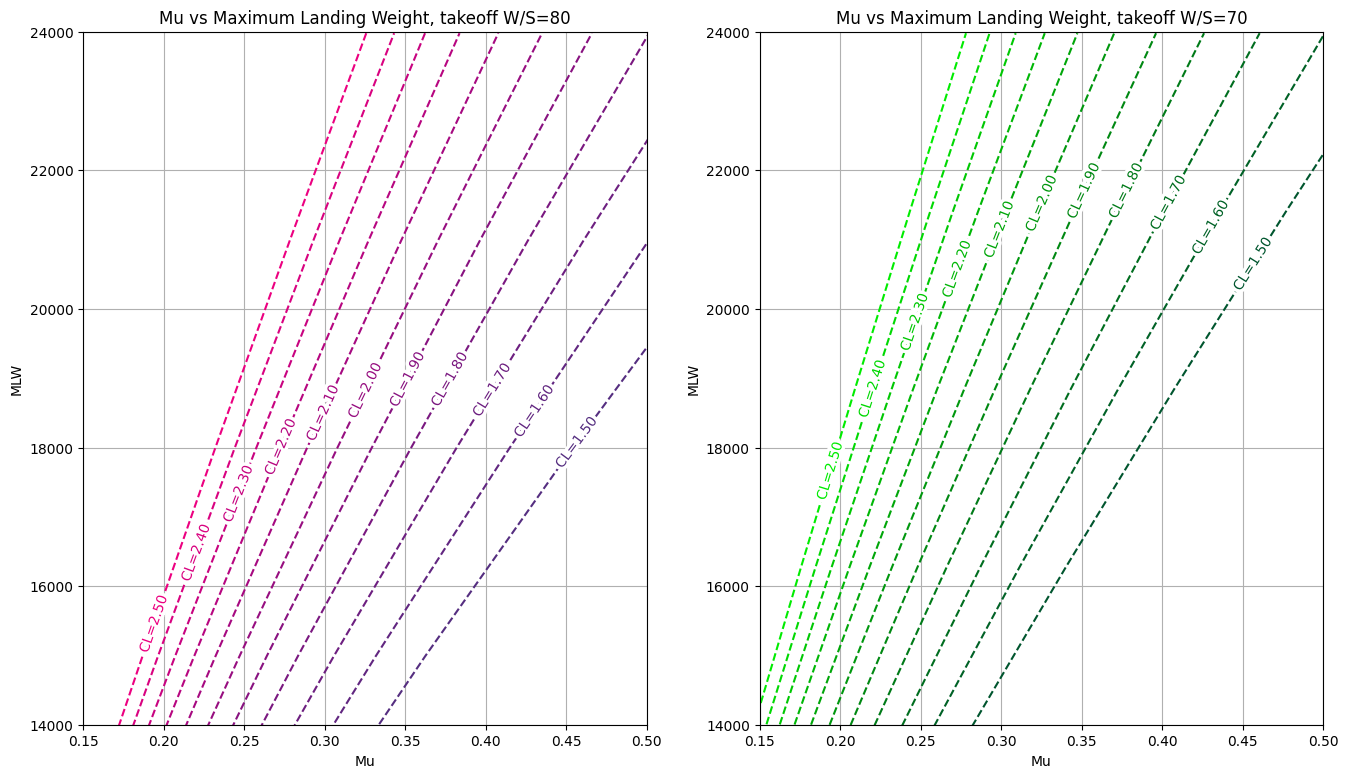

In [ ]:
#CLMAX INVESTIGATION
from scipy.optimize import fsolve
from labellines import labelLine, labelLines



  # W_S = (S_ldg-19.08*h_obst) * (rho*CLmax_ldg) / \
  #         (0.007923+1.556*t_roll*math.sqrt(rho*CLmax_ldg/W_S) + \
  #         1.21/(g*(0.605/CLmax_ldg*(CD_ldg-mu_ldg*CL_ldg) + mu_ldg - T_gr_W)))
  # W_S = W_S/w_frac_climb


#Using http://www.atr-aircraft.com/wp-content/uploads/2020/07/42-300.pdf

#Good resource for ATR42-300 braking:
#https://www.theairlinepilots.com/forumarchive/atr/atr-cold-weather-operations.pdf
#W_S at MLW
W_S_landing_arr = np.linspace(40, 80, 15)

W_S_takeoff = 80
MLW=our_ac_weight
wing_area = our_ac_weight/80



fig, (ax, ax2) = plt.subplots(1, 2)




h_obst = 35                                   #Obstacle height (ft)
t_roll = 1                                    #Roll time before brakes applied (seconds)
alt_ldg = 0                                   #Landing altitude                           
g = Atmosphere(alt_ldg/km_to_ft*1000).grav_accel*(km_to_ft/1000) #g
rho = Atmosphere(alt_ldg/km_to_ft*1000).density*kgm3_to_slft3
CL_ldg = 0.5                                  #CL_ldg (assumed)
CD_ldg = 0.07                                 #CD_ldg (assumed)
mu_ldg = 0.3                                  #ground friction (assumed)
T_gr_W = -0                                   #idle T_W (assume 0 for now)
S_ldg = 0.8*km_to_ft                          #Total landing distance, ft
CLmax_ldg = 2.25

val = lambda mu_ldg, W_S:  W_S - (S_ldg-19.08*h_obst) * (rho*CLmax_ldg) / \
        (0.007923+1.556*t_roll*math.sqrt(rho*CLmax_ldg/W_S) + \
        1.21/(g*(0.605/CLmax_ldg*(CD_ldg-mu_ldg*CL_ldg) + mu_ldg - T_gr_W)))

CL_ldg_arr = np.arange(1.5, 2.6, 0.1)

W_S_takeoff = 80
W_S_landing_arr = np.linspace(40, W_S_takeoff, 5)
wing_area = our_ac_weight/W_S_takeoff

for CLmax_ldg in CL_ldg_arr:
  mu = (fsolve(val, x0=1, args=W_S)[0] for W_S in W_S_landing_arr)
  mu = list(mu)
  ax.plot(mu, W_S_landing_arr*wing_area, color=((CLmax_ldg/2.6)**2,(1-CLmax_ldg/2.6)**2,0.5,1), ls='--', label=f'CL={CLmax_ldg:.2f}')



W_S_takeoff = 70
W_S_landing_arr = np.linspace(40, W_S_takeoff, 5)
wing_area = our_ac_weight/W_S_takeoff



for CLmax_ldg in CL_ldg_arr:
  mu = (fsolve(val, x0=1, args=W_S)[0] for W_S in W_S_landing_arr)
  mu = list(mu)
  ax2.plot(mu, W_S_landing_arr*wing_area, color=(0,(CLmax_ldg/2.6)**2,((1-CLmax_ldg/2.6)**2),1), ls='--', label=f'CL={CLmax_ldg:.2f}')


ax.set_ylabel('MLW')
ax.set_xlabel('Mu')
ax.set_title('Mu vs Maximum Landing Weight, takeoff W/S=80')
ax.set_xlim(0.15, 0.5), ax.set_ylim(14000, 24000)
labelLines(ax.get_lines(), zorder=2.5)
ax.grid()


ax2.set_ylabel('MLW')
ax2.set_xlabel('Mu')
ax2.set_title('Mu vs Maximum Landing Weight, takeoff W/S=70')
ax2.set_xlim(0.15, 0.5), ax2.set_ylim(14000, 24000)
labelLines(ax2.get_lines(), zorder=2.5)
ax2.grid()

fig.set_size_inches(16, 9)

plt.show()



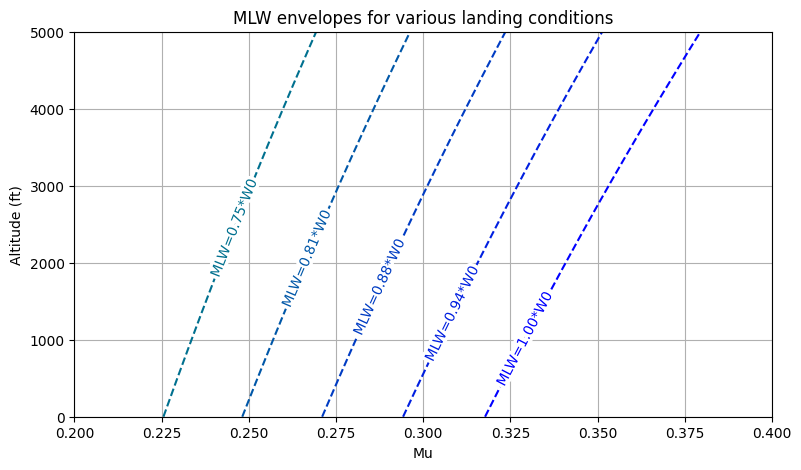

In [ ]:
#MLW Envelope Investigation
fig, ax = plt.subplots()


alt = np.linspace(0, 5000, RES)
rho_arr = Atmosphere(alt/km_to_ft*1000).density*kgm3_to_slft3

CLmax_ldg = 2.25

W_S_takeoff = 70
W_S_landing_arr = np.linspace(52.5, W_S_takeoff, 5)
wing_area = our_ac_weight/W_S_takeoff

mlw_landing_arr = W_S_landing_arr*wing_area
val = lambda mu_ldg, rho, W_S:  W_S - (S_ldg-19.08*h_obst) * (rho*CLmax_ldg) / \
        (0.007923+1.556*t_roll*math.sqrt(rho*CLmax_ldg/W_S) + \
        1.21/(g*(0.605/CLmax_ldg*(CD_ldg-mu_ldg*CL_ldg) + mu_ldg - T_gr_W)))

for W_S, MLW in zip(W_S_landing_arr, mlw_landing_arr): 
  mu = (fsolve(val, x0=1, args=(rho, W_S))[0] for rho in rho_arr)
  mu = list(mu)
  frac = MLW/our_ac_weight
  ax.plot(mu, alt, color=(0,1-(W_S/70)**2,((W_S/70)**2),1), ls='--', label=f'MLW={frac:.2f}*W0')


ax.set_ylabel('Altitude (ft)')
ax.set_xlabel('Mu')
ax.set_title('MLW envelopes for various landing conditions')
ax.set_xlim(0.2, 0.4), ax.set_ylim(0, 5000)
labelLines(ax.get_lines(), xvals=(0.225, 0.35), zorder=2.5)
ax.grid()
fig.set_size_inches(9, 5)

plt.show()



0.9675629961237099
      Frac            W0    total_fuel    fuel_fuel  fuel_reduction_percent
0    0.000  23978.558516   3112.730336  3112.730336                0.000000
1    0.001  23981.284540   3115.456360  3112.340904                0.000125
2    0.002  23984.015343   3118.187164  3111.950789                0.000250
3    0.003  23986.750938   3120.922758  3111.559990                0.000376
4    0.004  23989.491337   3123.663157  3111.168505                0.000502
..     ...           ...           ...          ...                     ...
995  0.995  44925.579570  24059.751391   120.298757                0.961353
996  0.996  45089.410562  24223.582383    96.894330                0.968872
997  0.997  45255.488012  24389.659833    73.168979                0.976494
998  0.998  45423.858445  24558.030266    49.116061                0.984221
999  0.999  45594.569678  24728.741499    24.728741                0.992056

[1000 rows x 5 columns]
      Frac            W0    total_fuel    fu

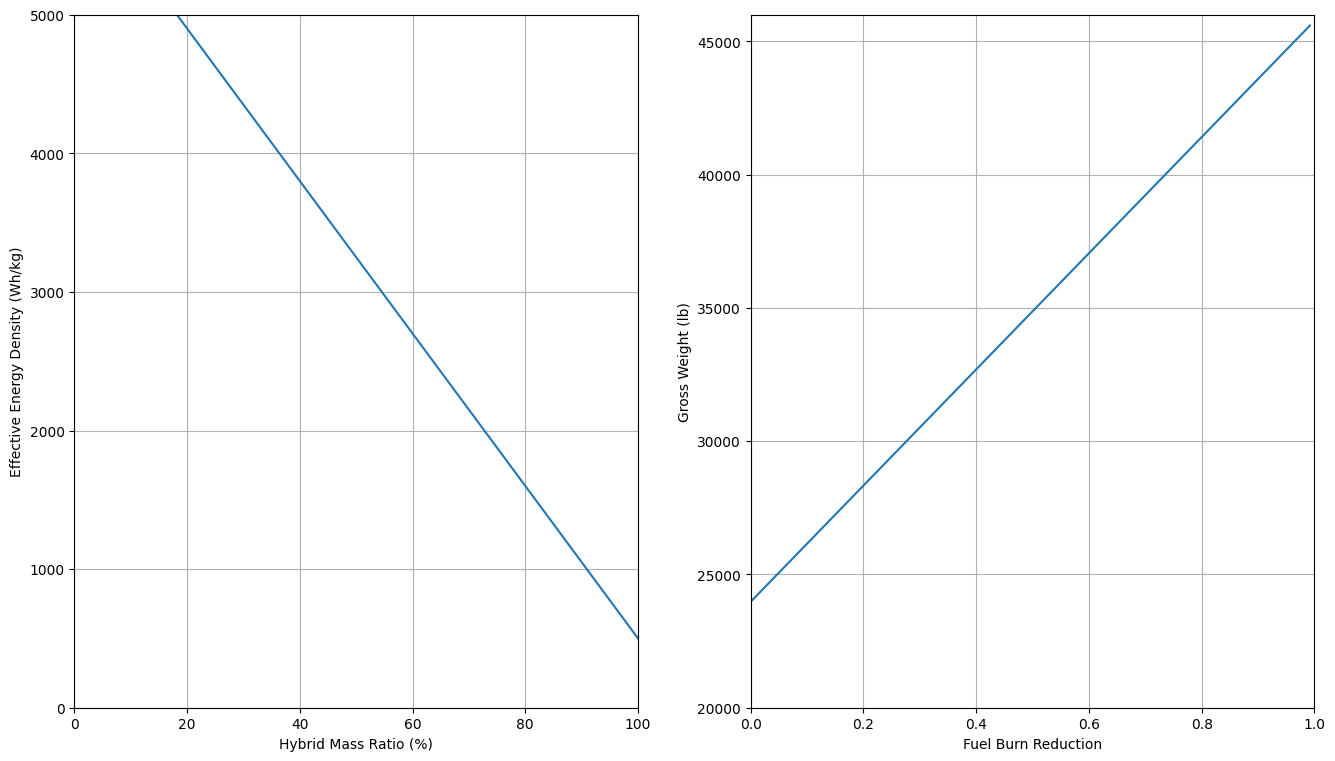

In [ ]:
#ENERGY DENSITY
import pandas as pd
battery_energy_density = 500
fuel_effective_energy_density = 4000

p_hyb = np.linspace(0, 100, RES, endpoint=True)
combined_energy_density = np.linspace(6000, 500, RES, endpoint=True)

fig, (ax, ax2) = plt.subplots(1, 2)

ax.set_ylabel('Effective Energy Density (Wh/kg)')
ax.set_xlabel('Hybrid Mass Ratio (%)')
ax.set_title('')
ax.set_xlim(0,100), ax.set_ylim(0,5000)
labelLines(ax.get_lines(), xvals=(0.225, 0.35), zorder=2.5)
ax.grid()
fig.set_size_inches(16, 9)
ax.plot(p_hyb, combined_energy_density)



#FOR OUR AIRCRAFT
aspect_ratio = 11.08 #aspect ratio estimate
Swet_Sref = 5 #wetted area ratio estimate
L_D_max = L_D_max_estimate(aspect_ratio, Swet_Sref)
R = 500*km_to_ft #Range in ft
C_cruise = 0.5/h_to_sec #
C_loiter = 0.6/h_to_sec #
V = 250*kts_to_fps #speed
w_payload = pax_weight_est(30, 0.5) #30 passengers
w_crew = crew_weight_est(3, 0.5) #3 crew (2 pilot and 1 flight attendant)
E = 1/3*h_to_sec #loiter time estimate



wf_frac = wf_frac_estimate(R, C_cruise, C_loiter, V, L_D_max, E)
w0_guess = 20000
w0 = iterate_weight(w_crew, w_payload, wf_frac, w0_guess, diff=0.005)
w0_initial = w0
empty_weight = w0*we_frac_estimate(w0)
fuel_weight = w0*wf_frac

x = np.arange(0,1,0.001)
adjusted_fuel_weight = fuel_weight*(4000/(4000*(1-x)+500*(x)))


add_weight = adjusted_fuel_weight - fuel_weight 

w0 = w0+add_weight


df = pd.DataFrame({'Frac': x,'W0': w0, 'total_fuel': adjusted_fuel_weight })


df['fuel_fuel'] = df.apply(lambda var: var['total_fuel']*(1-var['Frac']), axis=1)
# df['bat_fuel'] = df.apply(lambda var: var['total_fuel']*(var['Frac']), axis=1)

df['fuel_reduction_percent'] = df.apply(lambda var: 1-var.fuel_fuel/fuel_weight, axis=1)
print(df)
print(df.loc[df['fuel_reduction_percent'] >= 0.5])
ax2.plot(df['fuel_reduction_percent'], w0)


ax2.set_ylabel('Gross Weight (lb)')
ax2.set_xlabel('Fuel Burn Reduction')
ax2.set_title('')
ax2.set_xlim(0,1), ax2.set_ylim(20000,46000)
ax2.grid()

# x2 = np.arange(0,0.85,0.01)
# adjusted_fuel_weight = fuel_weight*(4000/(4000*(1-x2)+750*(x2)))
# adjusted_wf_frac = (adjusted_fuel_weight)/w0_initial
# print(adjusted_fuel_weight, adjusted_wf_frac)
# w0_guess = 20000
# w0_2 = (iterate_weight(w_crew, w_payload, wf_frac, w0_guess, diff=0.005) for wf_frac in adjusted_wf_frac)
# w0_2 = list(w0_2)
# # empty_weight = w0*we_frac_estimate(w0)
# # fuel_weight = w0*adjusted_wf_frac
# print(fuel_weight)

# ax2.plot(x2, w0_2)

# x2 = 0.33
# adjusted_fuel_weight = fuel_weight*(4000/(4000*(1-x2)+750*(x2)))
# adjusted_wf_frac = (adjusted_fuel_weight)/w0_initial
# print(adjusted_fuel_weight, adjusted_wf_frac)
# w0_guess = 20000
# w0_2 = iterate_weight(w_crew, w_payload, adjusted_wf_frac, w0_guess, diff=0.005)

# print(x2, w0_2*adjusted_wf_frac, w0_2)
# # empty_weight = w0*we_frac_estimate(w0)
# # fuel_weight = w0*adjusted_wf_frac





In [ ]:
#CG calculation script

def cg(arr):
  #function takes a numpy 2d array in the form [[loc, mass], [loc, mass] ...] then gives the cg location as [loc, mass]
  moment = 0
  mass = 0
  for entry in arr:
    moment+=entry[0]*entry[1]
    mass+=entry[1]
  loc = moment/mass
  return([loc, mass])


1670.2593301745462 111.88066831316081 145.7077950252917 5077.588492035429 686.4755089321875 333.22844414094567 632.294863031565 1840 90.0 68.41372928680505 66.62461125445944 235.4 145.03212882073043 98.81130283493998 686.6334771185096 1538.3179338942507 500.5859459139546 0.0 47.958 7.193700000000001
Empty weight estimate: 13982.405930776775
Percent difference: 0.005711424208931509


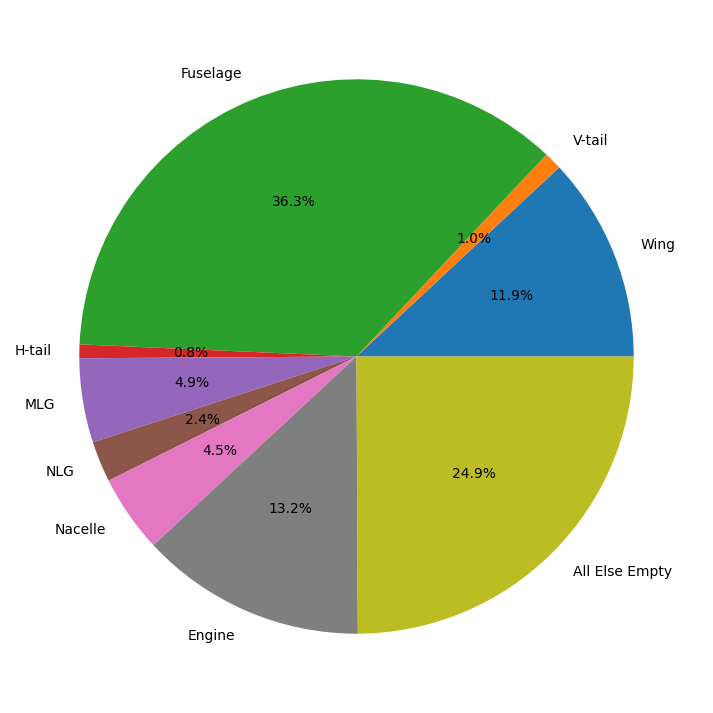

In [ ]:
#COMPONENT-WISE STATISTICAL ESTIMATION USING RAYMER'S

W_dg=23979 #flight design gross weight
N_z=1.5*3.8 #1.5 times limit load factor, taken as 3.8 (https://www.law.cornell.edu/cfr/text/14/25.337)
S_w = 343 #wing surface area
A=11 #wing AR
t_c_root=0.18 #airfoil thickness ratio (NACA 23018)
lam=0.5 #taper ratio
ang=np.radians(3) #quarter chord sweep angle, approx.
S_csw=53 #control surface area, approx.
B_w = 61.42 #wing span

wing_weight = lambda:  (0.0051*(W_dg*N_z)**0.557) \
                    *(S_w**0.649)*(A**0.5)*(t_c_root)**(-0.4) \
                    *((1+lam)**0.1)*(np.cos(ang)**-1)*(S_csw**0.1)

K_uht = 1 #fixed tail, constant
F_w = 3 #fuselage width at H-tail intersection, approximate
S_ht = 55.98 #horizontal tail area
B_h = 14.96 #H tail span
L_t = 31.93 #tail moment arm
K_y = 0.3*L_t #pitching moment of gyration, approx. from Raymer's
ang_ht = np.radians(10) #approximate, 10 deg
A_h = 4 #h-tail AR
S_e = S_ht*0.3 #Elevator area estimate


h_tail_weight = lambda: (0.0379*K_uht)*(1+F_w/B_h)**(-0.25)*(W_dg**0.639)\
                        *(N_z**0.1)*(S_ht**0.75)*(L_t**-1)*(K_y**0.704)\
                        *(np.cos(ang_ht)**-1)*(A_h**0.166)*(1+S_e/S_ht)**0.1

Ht_Hv = 1 #T-tail
S_v = 52.78 #vertical tail area
K_z = L_t #aircraft yawing radius of gyration, approx from Raymer
ang_vt = np.radians(15) #Estimate
A_v = 1.2 #V-tail AR

v_tail_weight = lambda: 0.0026*((1+Ht_Hv)**0.225)*(W_dg**0.556)*(N_z**0.536)\
                        *(L_t**-0.5)*(S_v**0.5)*(K_z**0.875)*(np.cos(ang_vt)**-1)\
                        *(A_v**0.35)*(t_c_root**-0.5)

K_door = 1.06 #Side cargo door
K_ldg = 1.12 #fuselage-mounted LG
L = 63.87 #fuselage length
D = 7.85 #Diameter
#print(np.pi*L*D) #Overestimate of wetted area, cylindrical area
S_f = np.pi*L*D #Overestimate of wetted area, cylindrical area

K_ws = 0.75*(1+2*0.5)/(1+0.5)*(B_w)*np.tan(ang) #See parameter in Raymer's

fus_weight = lambda: 0.3280*K_door*K_ldg*((W_dg*N_z)**0.5)*(L**0.258)*(S_f**0.302)\
                      *((1+K_ws)**0.04)*(L/D)**0.1

K_mp = 1.0 #Not kneeling
W_l = 23979 #want to be able to land at MTOW, extra safety
N_l = 2*1.5 #N_gear*1.5
L_m = 24 #Approximate
N_mw = 4 #2 per strut
N_mss = 2 #2 per leg
V_stall = 120 #Using approach speed, overestimate

mlg_weight = lambda: 0.0106*K_mp*(W_l**0.888)*(N_l**0.25)*(L_m**0.4)\
                     *(N_mw**0.321)*(N_mss**-0.5)*(V_stall**0.1)

K_np = 1 #Not kneeling
L_n = 24 #Guess, 24in?
N_w = 7.85 #assume cylindrical for now

nlg_weight = lambda: 0.032*K_np*(W_l**0.646)*(N_l**0.2)*(L_n**0.5)*(N_w**0.45)

N_en = 2 #no. engines
K_ng = 1 #not pylon-mounted
N_lt = 3 #Nacelle length
W_eng = 920 #PW120 weight
Kp = 1.4 #propeller
Ktr = 1 #no jet-reverser
W_ec = 2.331*(W_eng**0.901)*Kp*Ktr #Weight equation for nacelle
S_n = 30 #nacelle wetted approx.

nacelle_weight = lambda: 0.6724*K_ng*(N_lt**0.1)*(N_w**0.294)*(N_z**0.119)*(W_ec**0.611)\
                          *N_en**0.984*S_n**0.224

engine_weight = lambda: N_en*W_eng

L_ec = N_en*50 #assume approx. 50 feet of routing per engine

engine_controls = lambda: 5*N_en+0.8*L_ec

starter_weight = lambda: (49.19*(N_en*W_eng/1000)**0.541)

V_t = 3112/6.75 #3112 lb of fuel/6.75lb/gal = fuel volume
V_i = V_t*1.1 #integral tanks volume, assume 10% extra
V_p = V_t*0 #assume no self-sealing tanks
N_t = 2 #assume two tanks, one per wing

fuel_sys_weight = lambda: 2.405*(V_t**0.606)*((1+V_i/V_t)**-1)*(1+V_p/V_t)*N_t**0.5

N_f = 4 #rudder, elev, aileron, flap
N_m = 0 #assume all hydraulic
S_cs = 80 #approximate
I_yaw = 115000 #rough estimate using raymer's chapt.16 

flight_control_weight = lambda: 145.9*(N_f**0.554)*((1+N_m/N_f)**-1)*(S_cs**0.2)\
                                *(I_yaw*10**-6)**0.07

W_apu = 107 #apu weight estimated from this https://www.pbs.cz/en/Aerospace/Auxiliary-Power-Units/SAFIR-5K-G-Z8 

apu_weight = lambda: 2.2*W_apu


K_r = 1 #not reciprocating
K_tp = 0.793 #turboprop
N_c = 3 #3 crew
L_f = 63.87 #fuselage length

instruments_weight = lambda: 4.509*K_r*K_tp*(N_c**0.541)*N_en*(L_f+B_w)**0.5

hydraulic_weight = lambda: 0.2673*(N_f*(L_f+B_w)**0.937)

R_kva = 50 #rating of gen in KVA, estimate 50 from Raymer's
L_a = 60 #assume 60ft of electrical, gen to avionics to cockpit
N_gen = 2 #2 generators

electrical_weight = lambda: 7.291*(R_kva**0.782)*(L_a**0.346)*(N_gen**0.1)

W_uav = 1000 #Estimate from Raymer

avionics_weight = lambda: 1.73*(W_uav**0.983)

W_c = pax_weight_est(30) #Passenger weight

furnishings_weight = lambda: 0.0557*N_c**0.1*W_c**0.393*S_f**0.75

N_p = 33 #crew plus pax
V_pr = (7.82/2*np.pi)*(29.7+11.82) #pressurized section volume, for now approx. as cabin+main and cylindrical

air_conditioning_weight = lambda: 62.36*N_p*0*0.25*(V_pr/1000)**0.604*(W_uav**0.1)

anti_ice_weight = lambda: 0.002*W_dg

handling_gear_weight = lambda: 3*10**-4*W_dg

print(wing_weight(), h_tail_weight(), \
      v_tail_weight(), fus_weight(), mlg_weight(), \
      nlg_weight(), nacelle_weight(), engine_weight(), engine_controls(),\
      starter_weight(), fuel_sys_weight(), apu_weight(), instruments_weight(), \
      hydraulic_weight(), electrical_weight(), avionics_weight(), furnishings_weight(),\
      air_conditioning_weight(), anti_ice_weight(), handling_gear_weight())

empty_weight_second_iter = np.sum([wing_weight(), h_tail_weight(), \
      v_tail_weight(), fus_weight(), mlg_weight(), \
      nlg_weight(), nacelle_weight(), engine_weight(), engine_controls(),\
      starter_weight(), fuel_sys_weight(), apu_weight(), instruments_weight(), \
      hydraulic_weight(), electrical_weight(), avionics_weight(), furnishings_weight(),\
      air_conditioning_weight(), anti_ice_weight(), handling_gear_weight()])

#Last elements are summed to appear as "all else empty" group
data = np.array([wing_weight(),  \
      v_tail_weight(), fus_weight(), h_tail_weight(), mlg_weight(), \
      nlg_weight(), nacelle_weight(), engine_weight(), np.sum([engine_controls(),\
      starter_weight(), fuel_sys_weight(), apu_weight(), instruments_weight(), \
      hydraulic_weight(), electrical_weight(), avionics_weight(), furnishings_weight(),\
      air_conditioning_weight(), anti_ice_weight(), handling_gear_weight()])])
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)

labels = ['Wing',  'V-tail', 'Fuselage','H-tail', 'MLG', 'NLG', 'Nacelle', \
          'Engine', 'All Else Empty']
ax.pie(data, labels=labels, autopct='%1.1f%%')


print(f"Empty weight estimate: {empty_weight_second_iter}")
initial_sizing_estimate = 13903 #empty weight estimate
diff = abs(empty_weight_second_iter - initial_sizing_estimate)/initial_sizing_estimate
print(f"Percent difference: {diff}")




1670.2593301745462 1964.3569603943963


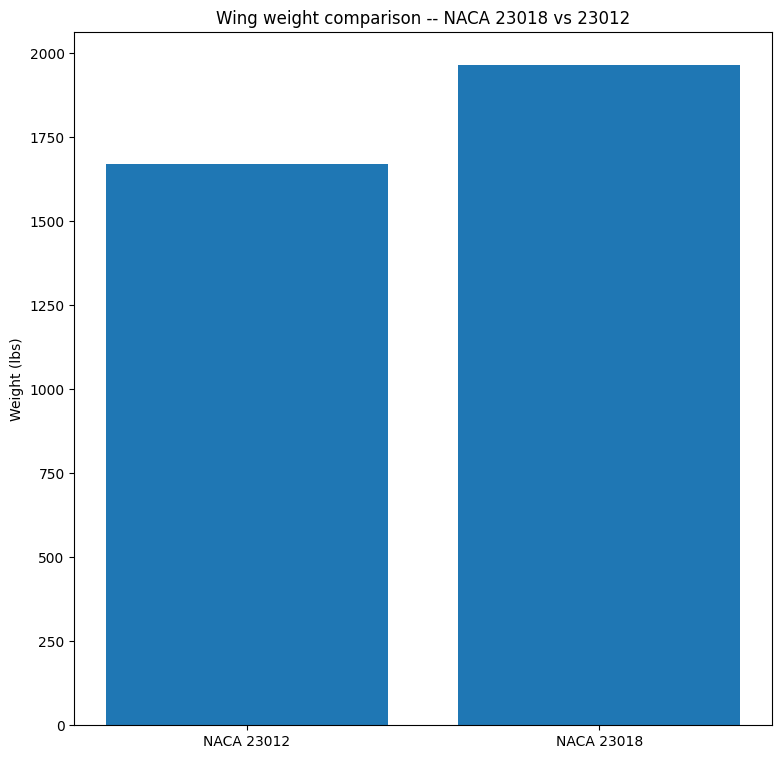

In [ ]:
W_dg=23979 #flight design gross weight
N_z=1.5*3.8 #1.5 times limit load factor, taken as 3.8 (https://www.law.cornell.edu/cfr/text/14/25.337)
S_w = 343 #wing surface area
A=11 #wing AR
lam=0.5 #taper ratio
ang=np.radians(3) #quarter chord sweep angle, approx.
S_csw=53 #control surface area, approx.
B_w = 61.42 #wing span

wing_weight = lambda:  (0.0051*(W_dg*N_z)**0.557) \
                    *(S_w**0.649)*(A**0.5)*(t_c_root)**(-0.4) \
                    *((1+lam)**0.1)*(np.cos(ang)**-1)*(S_csw**0.1)

fig, ax = plt.subplots()

t_c_root = 0.18 #airfoil thickness ratio (NACA 23018)
thickness_1 = wing_weight()
t_c_root = 0.12 #airfoil thickness ratio (NACA 23012)
thickness_2 = wing_weight()
fig.set_size_inches(9,9)
ax.set_title("Wing weight comparison -- NACA 23018 vs 23012")
ax.set_ylabel("Weight (lbs)")

ax.bar(["NACA 23012", "NACA 23018"], [thickness_1, thickness_2])
print(thickness_1, thickness_2)




<ipython-input-24-116cdec44100>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cg_comp = lambda p, f: cg(np.array([


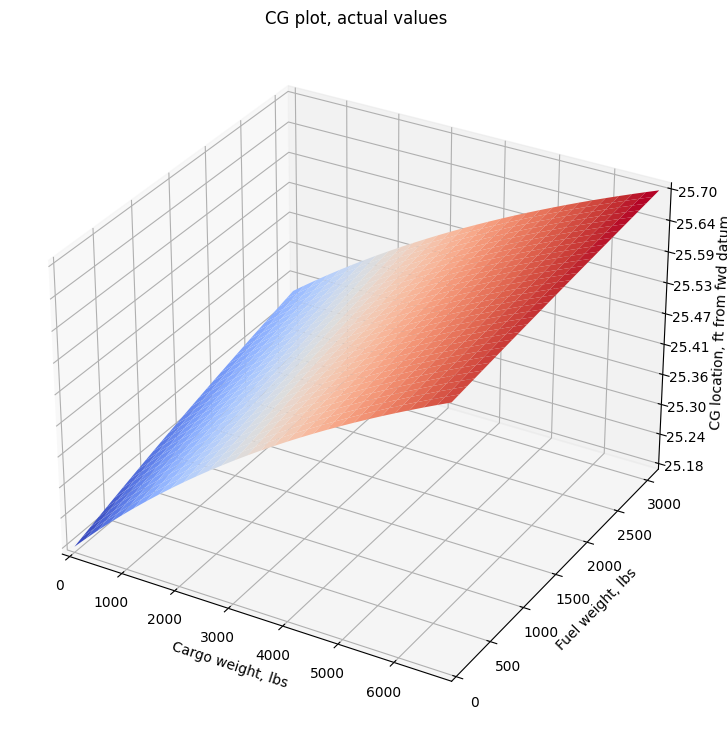

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FormatStrFormatter
#Component Weights 

payload_max = pax_weight_est(30)
fuel_max = 3124 #this fuel max was found by the fuel fraction, see Excel

crew_weight = pax_weight_est(3)

payload_arr = np.linspace(0, payload_max, 30)
fuel_arr = np.linspace(0, fuel_max, 30)
p_arr, f_arr = np.meshgrid(payload_arr, fuel_arr)

cg_comp = lambda p, f: cg(np.array([
                        [25.839, 13982], #empty weight
                        [29.70/2 + 11.82, p], #midpoint of central fuselage
                        [11.82, crew_weight], #all the way at the end of the cockpit, estimate to try and account for flight attendant being in the fuselage
                        [26, f]]))[0] #assuming for now that the CG of the fuel is at 26ft
                        

cg_locations = cg_comp(p_arr, f_arr)



fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(16, 9)

ax.set_title('CG plot, actual values')
ax.set_xlabel('Cargo weight, lbs')
ax.set_ylabel('Fuel weight, lbs')
ax.set_zlabel('CG location, ft from fwd datum')

ax.set_zlim(np.amin(cg_locations), np.amax(cg_locations))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlim(0, np.amax(p_arr))
ax.set_ylim(0, np.amax(f_arr))

ax.zaxis.set_major_locator(LinearLocator(10))

surf = ax.plot_surface(p_arr, f_arr, cg_locations, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)


25.700366459879167 25.182441747903745


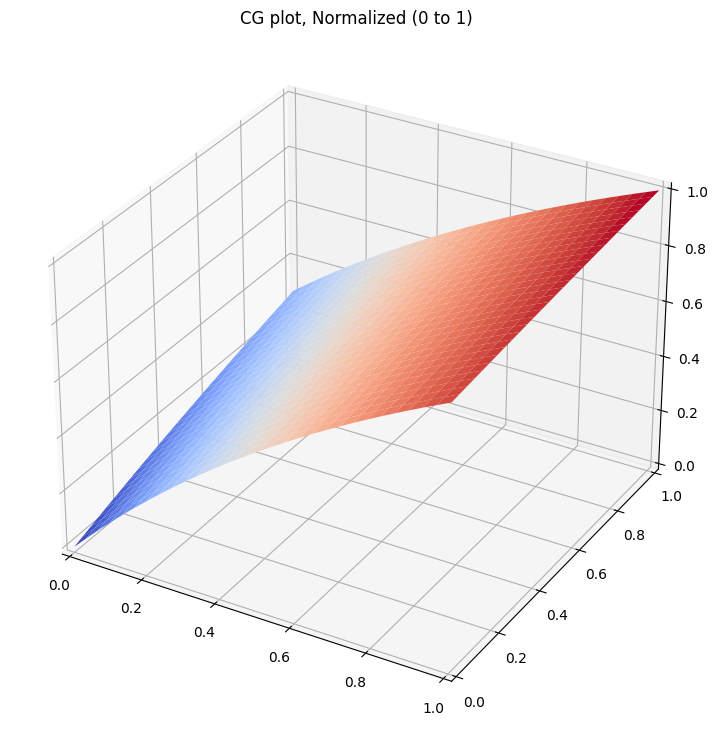

In [ ]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_title('CG plot, Normalized (0 to 1)')
fig.set_size_inches(16, 9)
ax.set_zlim(0, 1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
bound_x = np.amax(p_arr)
bound_y = np.amax(f_arr)
bound_z = np.amax(cg_locations)-np.amin(cg_locations)

X=(p_arr)/bound_x
Y=(f_arr)/bound_y
Z=(cg_locations-np.amin(cg_locations))/bound_z
print(np.amax(cg_locations), np.amin(cg_locations))

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
plt.show()



28.460560619674723 19.515401518199397



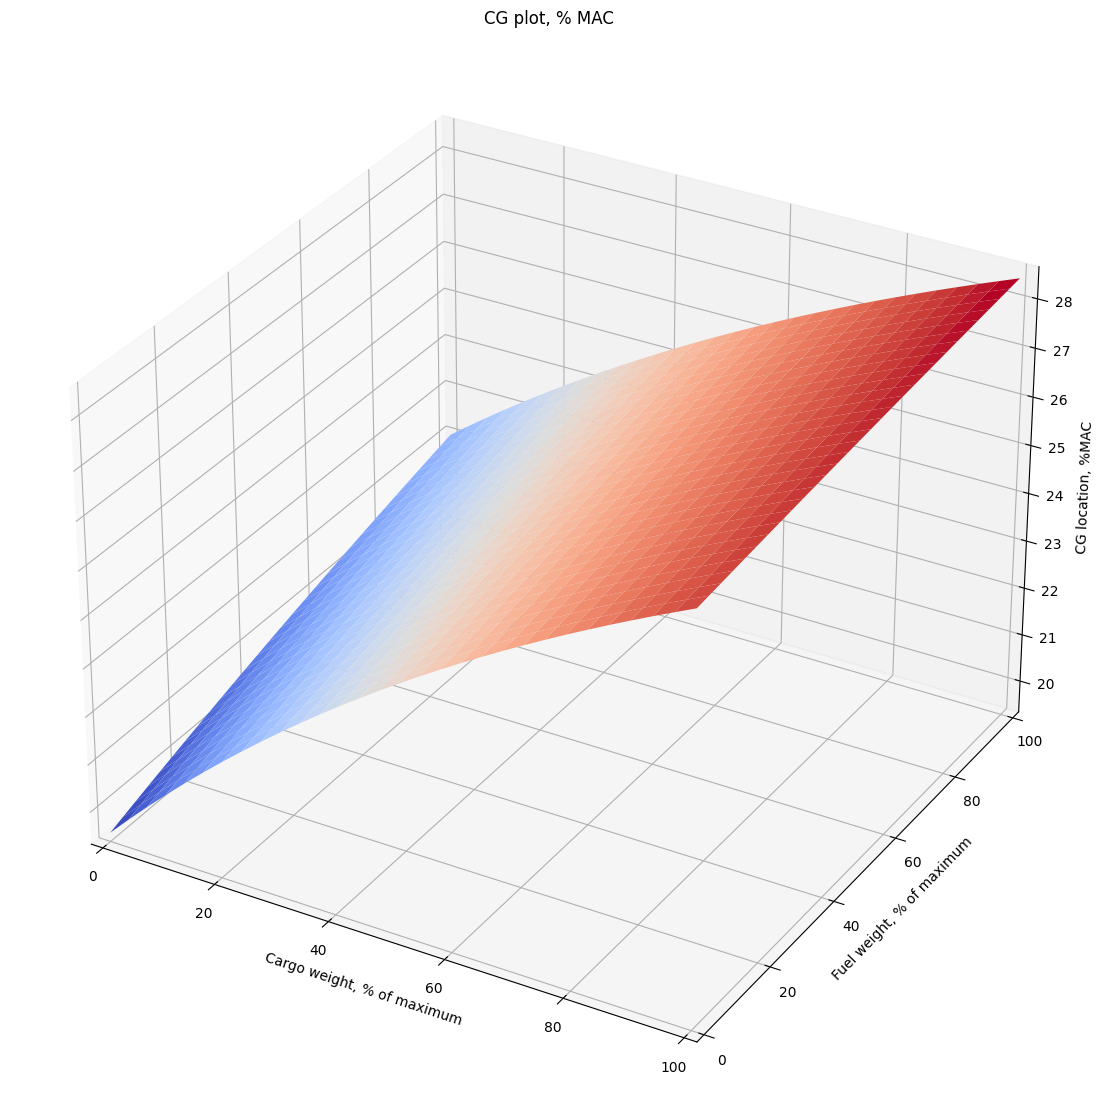

In [ ]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_title('CG plot, % MAC')
fig.set_size_inches(14,14)

ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
bound_x = np.amax(p_arr)
bound_y = np.amax(f_arr)
bound_z = np.amax(cg_locations)-np.amin(cg_locations)

ax.set_xlabel('Cargo weight, % of maximum')
ax.set_ylabel('Fuel weight, % of maximum')
ax.set_zlabel('CG location, %MAC')

X=(p_arr)/bound_x*100
Y=(f_arr)/bound_y*100

MAC = 5.79
qc_MAC = 25.5


Z=((cg_locations-25.5)/5.79+0.25)*100
Z_max = np.amax(Z)
Z_min = np.amin(Z)
print(Z_max, Z_min)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

print()
plt.show()


In [ ]:
#ESTIMATED RANGE IMPROVEMENT FROM AERODYNAMIC IMPROVEMENT
#CRUISE RANGE

cruise_frac = 0.9675629961237099 #cruise fraction found for our aircraft, see Initial Sizing section

C_cruise = 0.498/h_to_sec #Better estimate than 0.5 given in Raymer: http://www.srs.aero/wordpress/wp-content/uploads/2009/03/srs-tsd-002-rev-1-pw120a-sfc-analysis.pdf 

L_D_arr = np.linspace(17, 30, RES) #checking various L/D values between our initial estimate and our AeroVSP estimate with winglets
V=422 #ft/s

R = -(V*L_D_arr)/(C_cruise)*np.log(cruise_frac)
R=R/km_to_ft
L_D_est = 17 #Instead of using inaccurate openVSP estimate, using the previous L/D max estimate from initial sizing.
print(L_D_est)

print(-(V*L_D_est)/(C_cruise)*np.log(cruise_frac)/km_to_ft)



17
521.2318082228206


115.6233426371316


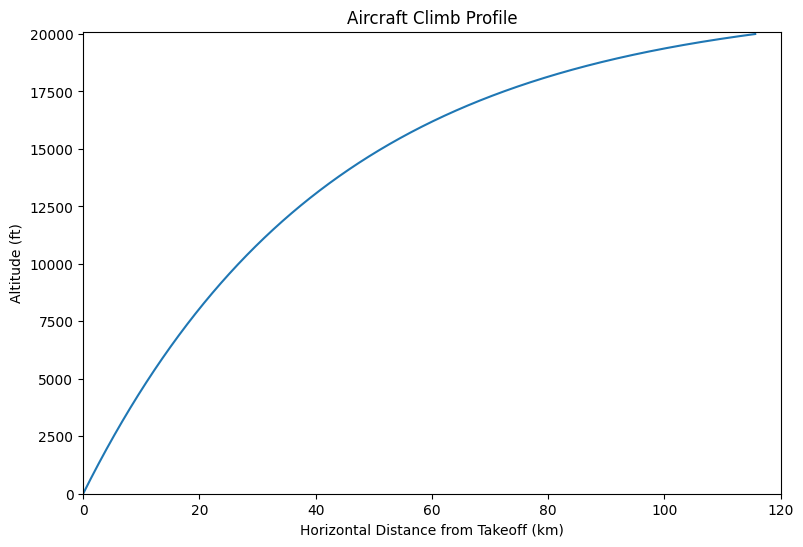

In [ ]:
#CLIMB RANGE: 
RES = 20000 #Improved resolution of 20,000 samples over 20,000ft gives a more accurate computation

fig, ax = plt.subplots()
ax.set_title('Aircraft Climb Profile')
fig.set_size_inches(9, 6)

ax.set_xlim(0, 120)
ax.set_ylim(0, 20100)

ax.set_xlabel('Horizontal Distance from Takeoff (km)')
ax.set_ylabel('Altitude (ft)')


#Note that the climb fuel fraction was assumed and not calculated, so this result is probably a bit off
#Better estimate would be finding the energy demand, but due to time constraints this was not possible 

#SPEED OF BEST CLIMB 
Vy=69.952+1.3402*(70) #70 lb/ft^2 wing loading, not including winglets


#Rate of climb curve
roc = lambda alt: (1400*(20000-alt)/(20000) + 100)/60 #linear decrease from 1500fpm at 0ft of altitude to 100fpm at 20k ft, converted to fps
angle = lambda alt: np.arcsin(roc(alt)/Vy) #Find angle based on hypoteneuse (Vy) and rate of climb (V_vertical)
del_x = lambda del_y, angle: del_y/np.tan(angle) #For each increment of altitude (del_y), find the corresponding increment of distance (del_x)

alt_array = np.linspace(0,20000,RES)
del_alt = np.full(RES, 20000/RES)
del_x_arr = del_x(del_alt, angle(alt_array))
x_arr = np.zeros(RES)
#Find running sum of distance increments wrt index
for i in range(1,RES):
  x_arr[i] = x_arr[i-1] + del_x_arr[i]

#Plot X distance in km vs Y distance in feet
ax.plot(x_arr/km_to_ft, alt_array)

#Final X distance estimate for climb segment, km
print(x_arr[-1]/km_to_ft)



In [ ]:
#FUEL BURN PER PAX*KM


#OUR ESTIMATE

eff1 = 1411/(30*(608+116.02)) #KG per PAX*KM
print(eff1)



#ATR 42-600 (Latest tech, take as stand-in for 2015 fuel burn for now)

eff2 = 4500/(50*1345) #KG per PAX*KM: https://www.atr-aircraft.com/our-aircraft/atr-42-600/ 
print(eff2)

#ATR 42-300 (Older tech, better result but worse argument for "2015" reduction)

eff3 = 4500/(48*831.53)#KG per PAX*KM https://www.atr-aircraft.com/wp-content/uploads/2020/07/42-300.pdf
print(eff3)

print(eff1/eff2)
print(eff1/eff3)

#NOTE: This is just the reduction in ONBOARD fuel burn, life-cycle assessment is improved by use of SAF

0.06496137307440863
0.06691449814126393
0.11274397796832344
0.9708116309453292
0.5761848592273389
